In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import datetime
from sklearn.preprocessing import LabelEncoder
import gc

import sklearn
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from tqdm.notebook import tqdm

#한글깨짐방지
plt.rc('font',family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

C:\Users\User\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\User\Anaconda3\lib\site-packages\distributed\config.py:63: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config.update(yaml.load(text) or {})


In [2]:
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))
print('Scikit-Learn : %s'%(sklearn.__version__))
!python --version

Pandas : 1.0.5
Numpy : 1.18.5
Scikit-Learn : 0.23.1


Python 3.6.5 :: Anaconda, Inc.


### data

In [3]:
#데이터로드
path = './data/'
data = pd.read_csv(path +'201901-202003.csv')
submission = pd.read_csv(path + 'submission.csv')

In [4]:
data.shape, submission.shape

((24697792, 12), (1394, 5))

### 전처리

#### 날짜변환

In [5]:
data.loc[data.CARD_CCG_NM.isna(),'CARD_CCG_NM'] = '세종'
data.loc[data.HOM_CCG_NM.isna(),'HOM_CCG_NM'] = '세종'

In [6]:
data = data.drop(['HOM_CCG_NM'],axis= 1)
columns = ['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC']
data = data.groupby(columns, as_index=False).sum().reset_index(drop=False)

In [7]:
data['year'] = data['REG_YYMM'].apply(lambda x : int(str(x)[:4]))
data['month'] = data['REG_YYMM'].apply(lambda x : int(str(x)[4:]))
# data.drop(['REG_YYMM'],axis= 1,inplace = True)

In [8]:
data.head()

,index,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
0,0,201901,강원,강릉시,건강보조식품 소매업,강원,20s,1,1,4,311200,4,2019,1
1,1,201901,강원,강릉시,건강보조식품 소매업,강원,30s,1,2,7,1374500,8,2019,1
2,2,201901,강원,강릉시,건강보조식품 소매업,강원,30s,2,2,6,818700,6,2019,1
3,3,201901,강원,강릉시,건강보조식품 소매업,강원,40s,1,3,4,1717000,5,2019,1
4,4,201901,강원,강릉시,건강보조식품 소매업,강원,40s,1,4,3,1047300,3,2019,1


### 추가변수
* 추가변수 결합시 7월의 경우 4월의 것으로 대체해야하나??? (현재 4월데이터 없음)

#### 18 사업체총조사

In [9]:
all_jobs_df = pd.read_csv('./data/외부데이터/18 사업체총조사_키워드매칭.csv',encoding = 'cp949')
all_jobs_df = all_jobs_df[['행정구역별','데이터업종명','사업체수 (개)', '종사자수 (명)']]
all_jobs_df.columns = ['CARD_SIDO_NM','STD_CLSS_NM', 'company','employee']
all_jobs_df.employee = all_jobs_df.employee.apply(lambda x : x.replace("X","0")).astype(int)
all_jobs_df = all_jobs_df.groupby(['CARD_SIDO_NM','STD_CLSS_NM'])[['company','employee']].sum().reset_index()

all_jobs_df = all_jobs_df[~(all_jobs_df.CARD_SIDO_NM == '전국')]

#### 지역내 각 업종이 차지하는 매출비중

In [20]:
def local_percent(data):
    '''
    2020-07-30 15:35:33 업종내 성별까지 분화시켜봄
    '''
    sample = data[data.year == 2019]
    pivoted = sample.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','SEX_CTGO_CD'],columns ='month',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    #각 지역별(시군구)업종의 매출비율을 저장
    sidos = pivoted.CARD_SIDO_NM.unique()

    local_percent_df = pd.DataFrame()
    for sido in sidos:
        sample_sido = pivoted[pivoted.CARD_SIDO_NM == sido]
        sigungus = sample_sido.CARD_CCG_NM.unique()
        for sigungu in sigungus:
            sample = sample_sido[sample_sido.CARD_CCG_NM == sigungu]
            sum_arr = sample.iloc[:,4:].sum().values.reshape(1,-1)
            parcent_df = (sample.iloc[:,4:]/sum_arr)*100

            fin = pd.concat([sample.iloc[:,:4],parcent_df],axis=1)
            local_percent_df = pd.concat([local_percent_df,fin])

    #신규변수 LP(local percent) : 지역내 각 업종이 차지하는 매출비중
    local_percent_df = local_percent_df.melt(id_vars=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','SEX_CTGO_CD'],value_name='LP')
    local_percent_df['month'] = local_percent_df['month'].astype(int)
    return local_percent_df

#### 전체업종에서 각 지역업종이 차지하는 매출비중

In [22]:
def job_percent(data):
    sample = data[data.year == 2019]
    pivoted = sample.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','SEX_CTGO_CD'],columns ='month',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    all_pivoted = data.pivot_table(index = ['STD_CLSS_NM'],columns ='month',values= "AMT",aggfunc= 'sum').reset_index()
    all_pivoted.fillna(0,inplace= True)
    all_pivoted = all_pivoted.set_index('STD_CLSS_NM')

    job_percent_df = pd.DataFrame()
    for job in all_pivoted.index:
        taget_df = pivoted[pivoted.STD_CLSS_NM == job]
        tail = (taget_df.iloc[:,4:]/all_pivoted.iloc[0].values)*100
        head = taget_df.iloc[:,:4]
        full = pd.concat([head,tail],axis =1)
        job_percent_df = pd.concat([job_percent_df,full])

    #신규변수 JP(Job percent): 전체업종에서 해당지역의 업종이 차이하는 비율
    job_percent_df = job_percent_df.melt(id_vars=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','SEX_CTGO_CD'],value_name='JP')
    job_percent_df['month'] = job_percent_df['month'].astype(int)
    return job_percent_df

In [23]:
def local_rate(data):
    sample = data[data.year == 2019]
    sample.loc[sample.CARD_SIDO_NM == sample.HOM_SIDO_NM,'AMT_local'] = 1
    sample.loc[sample.CARD_SIDO_NM != sample.HOM_SIDO_NM,'AMT_local'] = 0
    local_rate_df = sample.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','SEX_CTGO_CD','month'],columns = 'AMT_local',values = 'AMT',aggfunc = 'sum',fill_value= 0).reset_index()
    local_rate_df['local_AMT'] = local_rate_df[1.0]/(local_rate_df[0.0] +local_rate_df[1.0]) *100
    
    local_rate_df.drop([0.0,1.0],axis=1, inplace= True)
    
    return local_rate_df

In [24]:
def cust_differ(data):
    data['differ'] = (data.CNT- data.CSTMR_CNT)
    
    #2019만 사용
    data = data[data.year == 2019]
    
    #양수(단골)
    plus_custom = data[data['differ']>0]
    pivot_plus = plus_custom.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','SEX_CTGO_CD'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_plus = pivot_plus.melt(id_vars=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','SEX_CTGO_CD'],value_name='loyal')
    melt_plus['year'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_plus['month'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[4:]))
    melt_plus.drop(['REG_YYMM','year'],axis= 1,inplace = True)
       
    #음수(환불)
    minus_custom = data[data['differ']<0]
    pivot_minus = minus_custom.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','SEX_CTGO_CD'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_minus = pivot_minus.melt(id_vars=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','SEX_CTGO_CD'],value_name='refund')
    melt_minus['year'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_minus['month'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[4:]))
    melt_minus.drop(['REG_YYMM','year'],axis= 1,inplace = True)
    
    #둘 결헙
    cust_differ_df = pd.merge(melt_plus,melt_minus,how= 'outer')
    
    return cust_differ_df

In [25]:
local_rate_df = local_rate(data)
local_percent_df = local_percent(data)
job_percent_df = job_percent(data)
cust_differ_df = cust_differ(data)

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### 추가변수 결합
* 모든변수에 성별로 더 세분화해봄

In [26]:
data.shape

(5328210, 15)

In [27]:
grouped = pd.merge(data,local_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','SEX_CTGO_CD','month'],how = 'left')
grouped = pd.merge(grouped,job_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','SEX_CTGO_CD','month'],how = 'left')
grouped = pd.merge(grouped,local_rate_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','SEX_CTGO_CD','month'],how = 'left')
grouped = pd.merge(grouped,cust_differ_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','SEX_CTGO_CD','month'],how = 'left')
grouped = pd.merge(grouped,all_jobs_df,on =['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')

In [28]:
grouped.shape

(5328210, 22)

In [29]:
grouped.columns

Index(['index', 'REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM',
       'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CSTMR_CNT', 'AMT', 'CNT',
       'year', 'month', 'differ', 'LP', 'JP', 'local_AMT', 'loyal', 'refund',
       'company', 'employee'],
      dtype='object')

In [30]:
grouped.head()

,index,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,...,year,month,differ,LP,JP,local_AMT,loyal,refund,company,employee
0,0,201901,강원,강릉시,건강보조식품 소매업,강원,20s,1,1,4,...,2019,1,0,0.058965,0.053904,100.0,3.0,NaN,263.0,399.0
1,1,201901,강원,강릉시,건강보조식품 소매업,강원,30s,1,2,7,...,2019,1,1,0.058965,0.053904,100.0,3.0,NaN,263.0,399.0
2,2,201901,강원,강릉시,건강보조식품 소매업,강원,30s,2,2,6,...,2019,1,0,0.079467,0.072647,100.0,8.0,-3.0,263.0,399.0
3,3,201901,강원,강릉시,건강보조식품 소매업,강원,40s,1,3,4,...,2019,1,1,0.058965,0.053904,100.0,3.0,NaN,263.0,399.0
4,4,201901,강원,강릉시,건강보조식품 소매업,강원,40s,1,4,3,...,2019,1,0,0.058965,0.053904,100.0,3.0,NaN,263.0,399.0


### 인코딩

#### 용량변환

In [31]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [32]:
#인코딩
def encoding(data):
    dtypes = grouped.dtypes
    encoders = {}
    for column in grouped.columns:
        if str(dtypes[column]) == 'object':
            encoder = LabelEncoder()
            encoder.fit(grouped[column])
            encoders[column] = encoder
    for column in encoders.keys():
        encoder = encoders[column]
        grouped[column] = encoder.transform(grouped[column])
    return encoders, data

In [33]:
encoders, grouped = encoding(grouped)

In [34]:
#메모리관리
grouped = reduce_mem_usage(grouped)

# del data
gc.collect()

Mem. usage decreased to 330.29 Mb (60.4% reduction)


321

### Model Tuning & Evaluation

In [35]:
def make_train_set(data):
    data1 = grouped[grouped.year == 2019]
    data2 = grouped[(grouped.year == 2020)&(grouped.month == 1)]
    train_set = pd.concat([data1,data2])
    return train_set

In [36]:
#2020.1까지 데이터로 20.04을 예측
train_set = make_train_set(grouped)
eval_set = grouped[(grouped.year == 2020)&(grouped.month == 3)]

In [37]:
params = {'random_state': 42,
          'learning_rate': 0.01,
          'max_depth': 8,
          'num_leaves': 64,
          'boosting': 'gbdt',
          'objective': 'regression',
          'metric': 'rmse',
          'feature_fraction': 0.9,
          'bagging_fraction': 0.7}

In [38]:
#세민님 파라미터
params = {
    'boosting_type': 'gbdt',
    'objective': 'tweedie',
    'metric': 'rmse',
    'tweedie_variance_power':1.1,
    'max_depth':11,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0}

In [39]:
#eval, train 구성
# train_x = train_set.drop(['CSTMR_CNT','AMT','CNT'],axis= 1)
# train_y = np.log1p(train_set['AMT'])

# eval_x = eval_set.drop(['CSTMR_CNT','AMT','CNT'],axis= 1)
# eval_y = np.log1p(eval_set['AMT'])

use_col = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month','company','employee', 
           'LP', 'JP','local_AMT','loyal','refund']
categorical_features = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','HOM_SIDO_NM','SEX_CTGO_CD','AGE','FLC']

train_ds = lgb.Dataset(train_set[use_col],
                       label=np.log1p(train_set['AMT']),
                       free_raw_data=False,
                       categorical_feature=categorical_features)
eval_ds = lgb.Dataset(eval_set[use_col],
                      label=np.log1p(eval_set['AMT']),
                      free_raw_data=False,
                      categorical_feature=categorical_features)

In [41]:
evaluation_results ={}
model = lgb.train(params,train_ds,
                  num_boost_round=5000,
                  valid_sets=[train_ds, eval_ds],
                  valid_names=['Train', 'Eval'],
                  verbose_eval=500,
                  early_stopping_rounds=100, evals_result = evaluation_results)

C:\Users\User\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[500]	Train's rmse: 0.929668	Eval's rmse: 1.03309
[1000]	Train's rmse: 0.813201	Eval's rmse: 0.952572
[1500]	Train's rmse: 0.761806	Eval's rmse: 0.92363
[2000]	Train's rmse: 0.73404	Eval's rmse: 0.91013
[2500]	Train's rmse: 0.715169	Eval's rmse: 0.902092
[3000]	Train's rmse: 0.700167	Eval's rmse: 0.895673
[3500]	Train's rmse: 0.689551	Eval's rmse: 0.891685
[4000]	Train's rmse: 0.680883	Eval's rmse: 0.887599
[4500]	Train's rmse: 0.673366	Eval's rmse: 0.884451
[5000]	Train's rmse: 0.666137	Eval's rmse: 0.881821
Did not meet early stopping. Best iteration is:
[5000]	Train's rmse: 0.666137	Eval's rmse: 0.881821


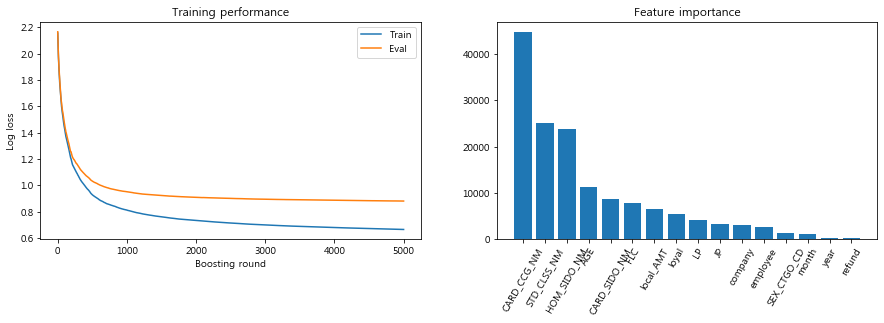

In [42]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['rmse'], label='Train')
axs[0].plot(evaluation_results['Eval']['rmse'], label='Eval')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': model.feature_name(), 
                            'importance': model.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'],rotation=60)
axs[1].set_title('Feature importance')

plt.show()

#### 예측탬플릿만들기

In [50]:
#new(예측탬플릿), 4월 7월 나눠서 진행
def make_temp(grouped,month = 4):
    ''' 예측용탬플릿 작성 
    data상에서 가능한 조합만 예측탬플릿으로 생성
    10대이면서 노년가구인 조합은 제외되게끔 함
    4월, 7월 나눠서 작성
    '''
    columns = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM', 'HOM_SIDO_NM','AGE','SEX_CTGO_CD',"FLC"]
    temp = grouped[columns].groupby(columns).sum().reset_index(drop=False)

    #추가변수 삽입
    #변수삽입을 위한 디코더
    temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
    temp['CARD_CCG_NM'] = encoders['CARD_CCG_NM'].inverse_transform(temp['CARD_CCG_NM'])
    temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])
    temp['year'] = 2020
    temp['month'] = month
#     temp['REG_YYMM'] = temp['year']*100 +temp['month']

    temp = pd.merge(temp,all_jobs_df,on =['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
    temp = pd.merge(temp,local_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','SEX_CTGO_CD','month'],how = 'left')
    temp = pd.merge(temp,job_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','SEX_CTGO_CD','month'],how = 'left')
    temp = pd.merge(temp,local_rate_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','SEX_CTGO_CD','month'],how = 'left')
    temp = pd.merge(temp,cust_differ_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','SEX_CTGO_CD','month'],how = 'left')

    temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].transform(temp['CARD_SIDO_NM'])
    temp['CARD_CCG_NM'] = encoders['CARD_CCG_NM'].transform(temp['CARD_CCG_NM'])
    temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].transform(temp['STD_CLSS_NM'])
    
    return temp

In [51]:
temp = make_temp(grouped,month = 4)

In [52]:
temp.head()

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,company,employee,LP,JP,local_AMT,loyal,refund
0,0,3,0,0,1,1,1,2020,4,263.0,399.0,0.038138,0.096807,100.0,NaN,-1.0
1,0,3,0,0,1,2,1,2020,4,263.0,399.0,0.069364,0.176068,100.0,1.0,-1.0
2,0,3,0,0,2,1,2,2020,4,263.0,399.0,0.038138,0.096807,100.0,NaN,-1.0
3,0,3,0,0,2,2,2,2020,4,263.0,399.0,0.069364,0.176068,100.0,1.0,-1.0
4,0,3,0,0,3,1,3,2020,4,263.0,399.0,0.038138,0.096807,100.0,NaN,-1.0


#### predict

In [54]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)

### 예측결과 담기

In [55]:
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])
temp['AMT'] = np.round(pred,0)
temp['REG_YYMM'] = temp['year']*100 +temp['month']

temp = temp[['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT']]
temp = temp.groupby(['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM']).sum().reset_index(drop=False)

In [56]:
temp

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202004,강원,건강보조식품 소매업,1.360803e+08
1,202004,강원,골프장 운영업,3.234072e+09
2,202004,강원,과실 및 채소 소매업,9.159677e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,3.379769e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,5.178700e+04
...,...,...,...,...
645,202004,충북,피자 햄버거 샌드위치 및 유사 음식점업,1.199902e+09
646,202004,충북,한식 음식점업,2.854160e+10
647,202004,충북,호텔업,3.640621e+07
648,202004,충북,화장품 및 방향제 소매업,5.836128e+08


#### 후처리

In [57]:
#제출파일
submission = pd.read_csv('data/submission.csv',index_col=0)

In [58]:
sub_04 = submission[submission.REG_YYMM == 202004]
del sub_04['AMT']

In [59]:
pre_df = pd.merge(sub_04,temp,how='left')
pre_df = pre_df.fillna(0)

In [60]:
only_4 = pd.read_csv('only_4.csv')
def set_sumit(only_4, pre_df):
    '''리더보드와 동일한 예측을 하는 함수
    parameter
    --------
    only_4(df) : 4월 RMSLE가 0이 나왔던 제출셋
    pre_df(df) : 모델로 예측한 Dataframe
    
    '''
    from sklearn.metrics import mean_squared_log_error
    
    pre_df = pre_df[pre_df['REG_YYMM'] == 202004]
    only_4 = only_4[only_4['REG_YYMM'] == 202004]
    
    pre_df.loc[pre_df.CARD_SIDO_NM == '제주','weight'] = 3
    pre_df.loc[pre_df.CARD_SIDO_NM != '제주','weight'] = 1
    
    weight = pre_df['weight'].values
    
    all_amt = np.sqrt(mean_squared_log_error(only_4['AMT'],pre_df['AMT'],sample_weight=weight))
    return all_amt

In [61]:
set_sumit(only_4, pre_df)

3.5171016994818483